### Random Forests, GBM, XGBoost, LightGBM, CatBoost

In [1]:
# Kütüphaneler

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

In [2]:
# Ekstra kütüphaneler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
# Pandas ayarları

pd.set_option('display.max_columns', None)
 
# Warnings ayarları
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
df = pd.read_csv("diabetes.csv")

In [5]:
y = df['Outcome']
X = df.drop(['Outcome'], axis=1)

In [6]:
#########################################
# Random Forests
#########################################

In [7]:
rf_model = RandomForestClassifier(random_state=17)

In [8]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [9]:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.753896103896104

In [10]:
cv_results["test_f1"].mean()

0.6190701534636385

In [11]:
cv_results["test_roc_auc"].mean()

0.8233960113960114

In [12]:
rf_params = {"max_depth": [5,8,None],
              "max_features": [3,5,7,"auto"],
              "min_samples_split": [2,5,8,15,20],
              "n_estimators": [100,200,500]}

In [13]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5,n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [14]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [15]:
# Final modeli kuralım.
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [16]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy","f1","roc_auc"])

In [17]:
cv_results["test_accuracy"].mean()

0.766848940533151

In [18]:
cv_results["test_f1"].mean()

0.6447777811143756

In [19]:
cv_results["test_roc_auc"].mean()

0.8271054131054132

In [20]:
# Değişkenlerin önemi. 

def plot_importance(model,features,num=len(X),save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_,"Feature": features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    
    if save:
        plt.savefig("importances.png")

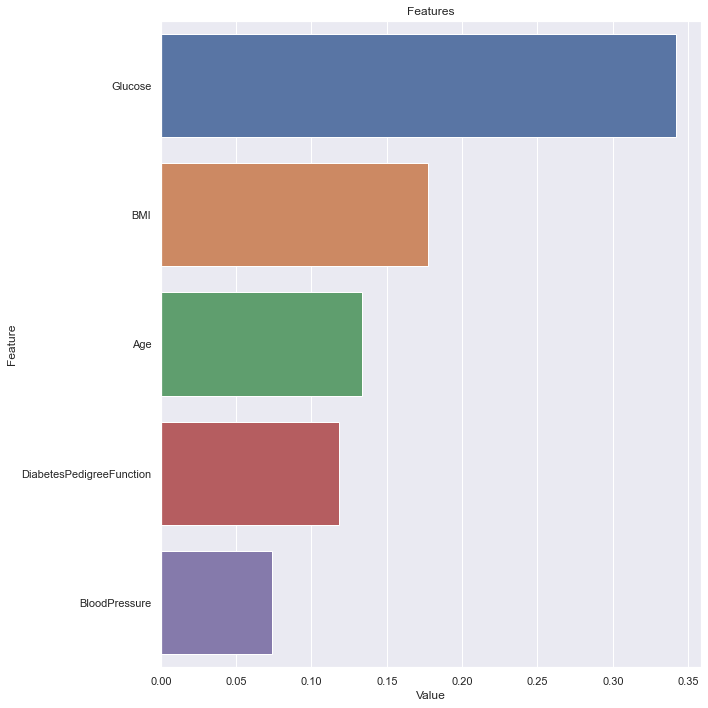

In [21]:
plot_importance(rf_final,X,num=5)

In [22]:
def val_curve_params(model,X,y,param_name,param_range,scoring="roc_auc",cv=10):
    train_score, test_score = validation_curve(model, X=X, y=y, param_name=param_name, param_range=param_range,scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,label="Training Score", color="b")
    plt.plot(param_range, mean_test_score,label="Validation Score", color="g")

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show(block=True)

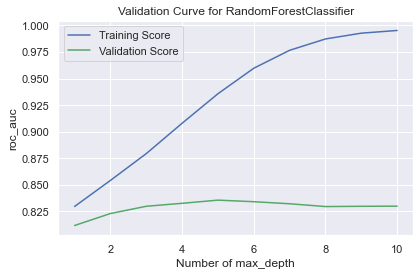

In [23]:
val_curve_params(rf_final,X,y,"max_depth",range(1,11),scoring="roc_auc")